# Benchmark C1.1: Coupled problems - Water uptake by a single root

by Andrea Schnepf, Daniel Leitner

In [1]:
import numpy as np
from scipy import optimize
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import ast
from van_genuchten import *

## Comparison of numerical solutions to reference solution

We compare different numerical codes by solving the benchmarking problems. In particular, we compare the shape and time of the water potential versus radius curve at the onset of stress. 

In addition, we provide links to Jupyter Notebooks that describe the numerical implementation of a benchmark problem in a specific code should they be available in the subfolder 'C1.1 Model descriptions'.

### Result data format of C1.1
 
For an automatic comparison of the numerical results, results are stored in a text file consisting of two rows containing comma separated radial distance values [cm]  in the first, and matric potential [cm] in the second row, at the first time stress occurs. This is done for each soil and transpiration rate scenario (i.e. 2 (rows) * 3 (soils) * 2 (transpiration rates) results = 12 rows). The files need to be located in the folder 'C1.1 Numerical results'.

### Comparison to the analytical solution of the steady rate approach

We first define the soil scenarios, and the rhizosphere geometry

In [2]:
sand = Parameters(0.045, 0.43, 0.15, 3, 1000,0.5) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50,0.5) 
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10,0.5) 
r_root = 0.02 # cm
r_out = 0.6 # cm
rho = r_out/r_root # 1

Next, we prepare the analytical solution plots for two transpiration scenarios 

In [3]:
def plot_analytical():
    global h_stressonset, wc_stressonset
    fig, ax = plt.subplots(2, 3,figsize=(14, 14))
    h_out = np.linspace(-100,-14500,100) #cm
    h_lim = -15000 # cm
    q_out = 0 # q_root * (r_root/(2*r_out))
    r = np.linspace(r_root, r_out, 30)
    h_stressonset = np.zeros((6,len(r))) 
    wc_stressonset = np.zeros((6,len(r)))
    ind = 0 
    soils = ["Sand", "Loam", "Clay"]
    for s,soil in enumerate([sand, loam, clay]): 
        for q,q_root in enumerate([0.1,0.05]):    # q_root in [cm/d], high and low transpiration
            crit = 0 
            k = 0
            while crit < 1:
                MFP_nostress = MFP(h_out[k],soil) + (q_root*r_root-q_out*r_out)*(r**2/r_root**2/(2*(1-rho**2))+rho**2/(1-rho**2)*(np.log(r_out/r)-0.5)) + q_out*r_out*np.log(r/r_out)
                if np.amin(MFP_nostress)<=0: # stress   
                    MFP_stress  = (MFP(h_out[k],soil)+q_out*r_out*np.log(1/rho))*( (r**2/r_root**2 - 1 + 2*rho**2*np.log(r_root/r))/(rho**2 - 1+2*rho**2*np.log(1/rho)) ) + q_out*r_out*np.log(r/r_root)
                    for i in range(len(r)):        
                        h_stressonset[ind,i] = h(MFP_stress[i],soil) 
                        wc_stressonset[ind,i] = water_content(h_stressonset[ind,i],soil)
                    crit=crit+1
                k=k+1

            Q = np.trapz(wc_stressonset[ind,:]*r,r)
            simtime=((r_out**2-r_root**2)*3.14*water_content(-100,soil) - Q*2*3.14)/(2*r_root*3.14*q_root)
            ax[int(q),int(s)].plot(r,h_stressonset[ind,:],'r*',label='Ref, '+"{:.1f}".format(simtime)+" day")
            ax[1,s].set_xlabel("distance to axis (cm)")
            ax[q,0].set_ylabel("soil water pressure head (cm)")
            ax[q,1].set_yticklabels([]);ax[int(q),2].set_yticklabels([])
            ax[q,s].set_ylim(-15000,0)
            ax[q,s].legend() 
            ax[q,s].title.set_text(soils[int(s)]+r', q$_{r}$='+"{:.2f}".format(q_root)+" cm/day")
            ind=ind+1
    return fig, ax
# fig, ax = plot_analytical()
# plt.show()

We compare the numerical results, i.e. the final soil profile, at the first time stress occurs, to the analytical steady rate approximation.

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


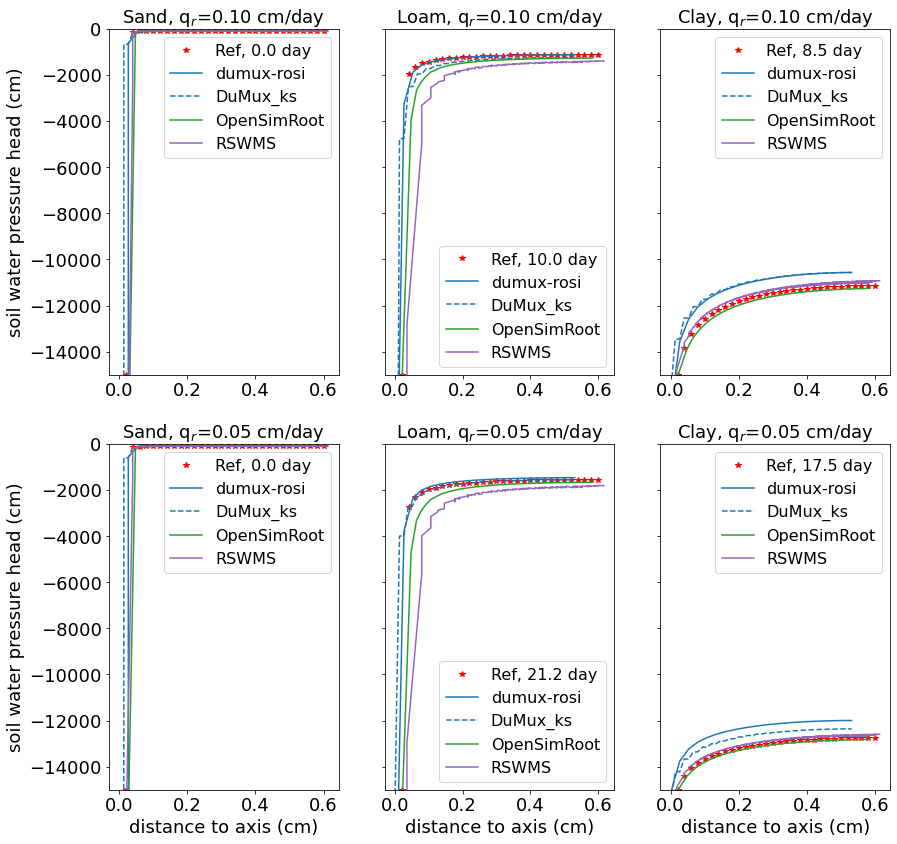

In [11]:
fig, ax = plot_analytical() # prepare analytic solution plot
r, nrmse, nn, l, lsoil, lqroot = [], [], [], [], [], []
lsoils=["Sand","Loam","Clay"] 
lqroots=[0.1,0.05]

for dirname, dirnames, filenames in os.walk('C1.1 Numerical results/.'):    
    filenames.sort(key=str.lower)
    for i,f in enumerate(filenames):            
        try: 
            data = []
            with open('C1.1 Numerical results/'+f) as fp: 
                for line in fp:
                    s = ast.literal_eval("["+line+"]")                
                    data.append(s)                
            for k in range(0,3): # axis
                for j in range(0,2): 
                    r_n = data[2*(3*j+k)]
                    h_n = data[2*(3*j+k)+1]  
                    if "_ks" in f:
                        c=col[i-1]; ls="dashed"
                    else:
                        c=col[i]; ls="solid"        
                    ax[j,k].plot(r_n, h_n, color = c, label = f, linewidth = 1.5, linestyle=ls) # numeric solution 
                    ax[j,k].legend() # update legend
                    l.append(f) 
                    lsoil.append(lsoils[k]) 
                    lqroot.append(lqroots[j])             
                    nn.append(len(h_n))                     
                    r_a = np.linspace(r_root, r_out, 30)
                    h_a = h_stressonset[3*j+k,:]
                    interp = interp1d(r_n, h_n, kind='linear',fill_value='extrapolate', bounds_error = False)
                    h_n = interp(sorted(r_a)) # numerical solution at points of analytical solution                                     
                    nrmse.append(nRMSE(h_a,h_n)) # calculate metrics                                                                       
        except Exception as ex:
            print("Something went wrong with file "+f)    
            raise                  

plt.savefig('c11_results.png', dpi=300, bbox_inches = "tight") 
plt.show()

Additionally, we create a table using normalised RSME as an error measure (which were calculated in the cell above)

C:\Users\a.schnepf\AppData\Local\Temp\ipykernel_33824\1882328161.py:11: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  df.style.set_table_styles(


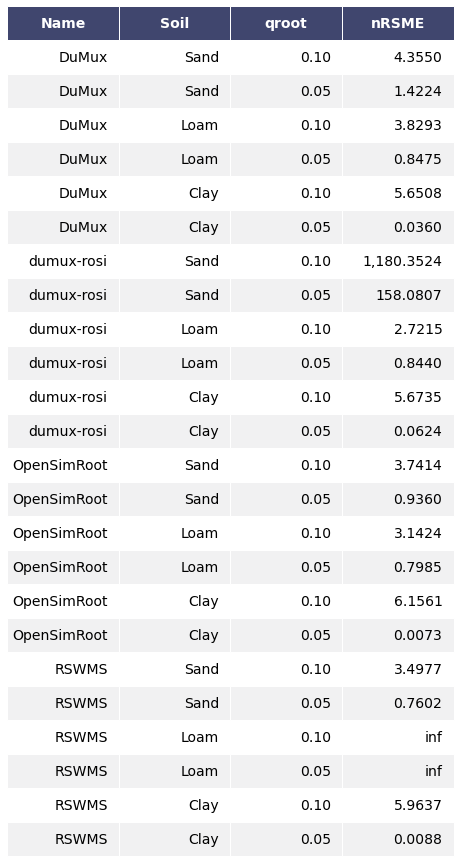

In [5]:
import pandas as pd 

data_ = np.array([l, lsoil, lqroot, nrmse])
data_ = np.array(data_.transpose())

df = pd.DataFrame(data_, columns = ['Name','Soil','qroot','nRSME'] ) # Create the pandas DataFrame 
df['qroot'] = df['qroot'].astype(float)
df['qroot'] = df['qroot'].map('{:,.2f}'.format)
df['nRSME'] = df['nRSME'].astype(float)
df['nRSME'] = df['nRSME'].map('{:,.4f}'.format)
df.style.set_table_styles(
[{'selector': 'tr:nth-of-type(odd)',
  'props': [('background', '#eee')]}, 
 {'selector': 'tr:nth-of-type(even)',
  'props': [('background', 'white')]},
 {'selector': 'th',
  'props': [('background', '#606060'), 
            ('color', 'white'),
            ('font-family', 'verdana')]},
 {'selector': 'td',
  'props': [('font-family', 'verdana')]},
]
).hide_index()

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
fig.savefig("table_c1l.png")

In [6]:
#sand = Parameters(0.02, 0.46, 0.0144, 1.534, 15.42, -0.215) 
#loam = Parameters(0.01, 0.42, 0.0084, 1.441, 12.98, -1.497)
#clay = Parameters(0.01, 0.59, 0.0195, 1.109, 4.53, -5.901)

## References

Schröder, T., Javaux, M., Vanderborght, J., Korfgen, B., and Vereecken, H. (2008). Effect of local soil hydraulic conductivity drop using a three-dimensional root water uptake model. *Vadose Zone Journal*, 7(3), 1089-1098.